In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:05<00:00, 137MB/s]
100% 5.20G/5.20G [01:05<00:00, 85.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model


In [ ]:
df = pd.read_csv('/content/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
df.shape

(10015, 7)

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
import os
import shutil

def combine_images(source_dirs, destination_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Iterate over each source directory
    for source_dir in source_dirs:
        # Iterate over each file in the source directory
        for filename in os.listdir(source_dir):
            # Get the full path of the source file
            source_path = os.path.join(source_dir, filename)
            # Get the full path of the destination file
            destination_path = os.path.join(destination_dir, filename)
            # Copy the file from the source directory to the destination directory
            shutil.copyfile(source_path, destination_path)

# Example usage:
source_dirs = ["/content/HAM10000_images_part_1", "/content/HAM10000_images_part_2"]
destination_dir = "/content/HAM10000_images"

combine_images(source_dirs, destination_dir)


In [ ]:
df['path'] = df['image_id'].map(lambda x: os.path.join(destination_dir, x + '.jpg'))
df['cell_type'] = df['dx'].map(lesion_type_dict)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [ ]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
df['age'].fillna((df['age'].mean()), inplace=True)


In [ ]:
df.isna().sum().sum()

0

<ipython-input-14-9f92caa76764>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex',data=df, palette = 'Paired')


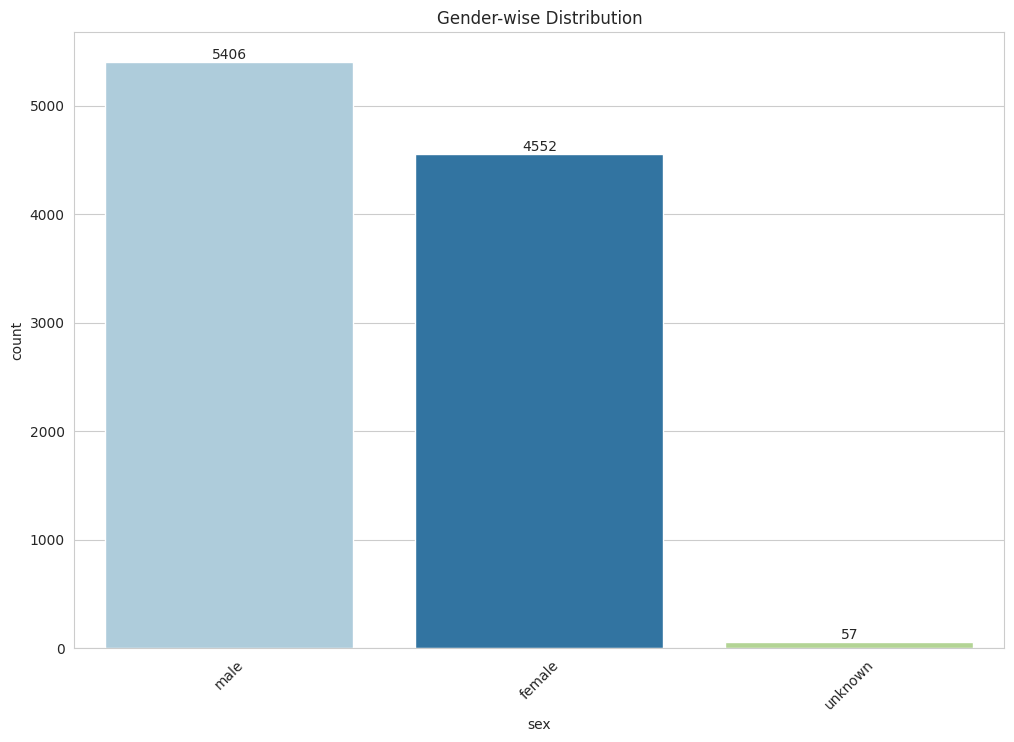

In [ ]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='sex',data=df, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-91834c66b92f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')


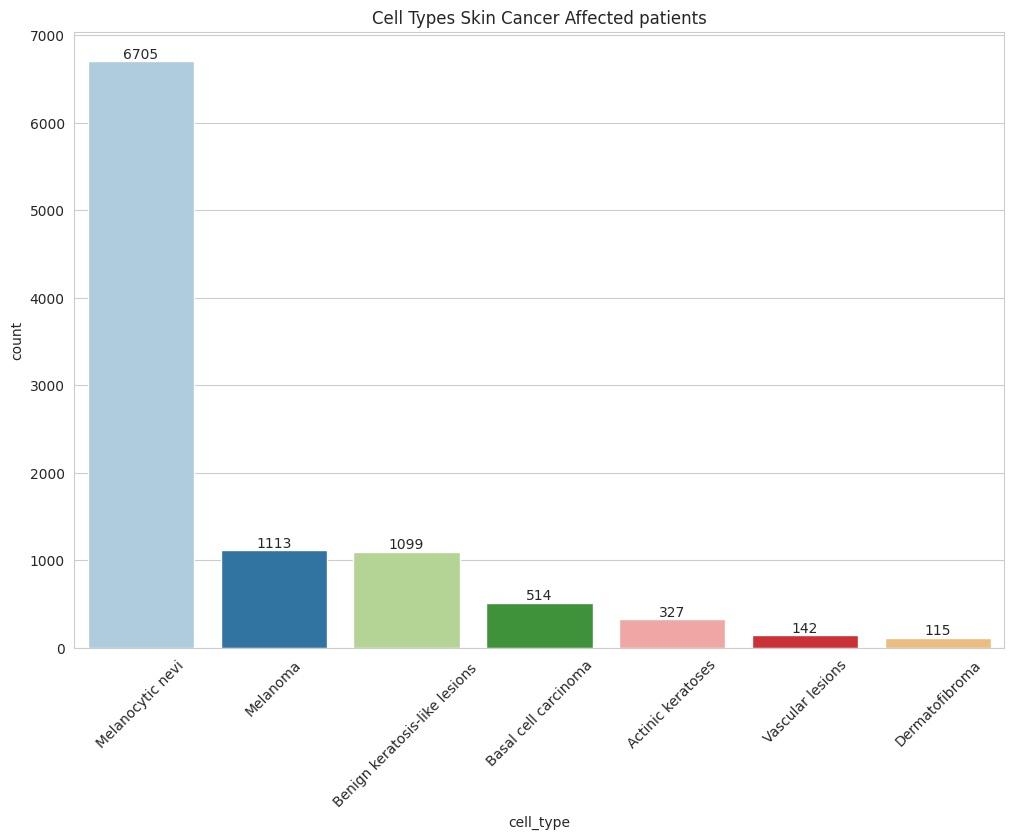

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

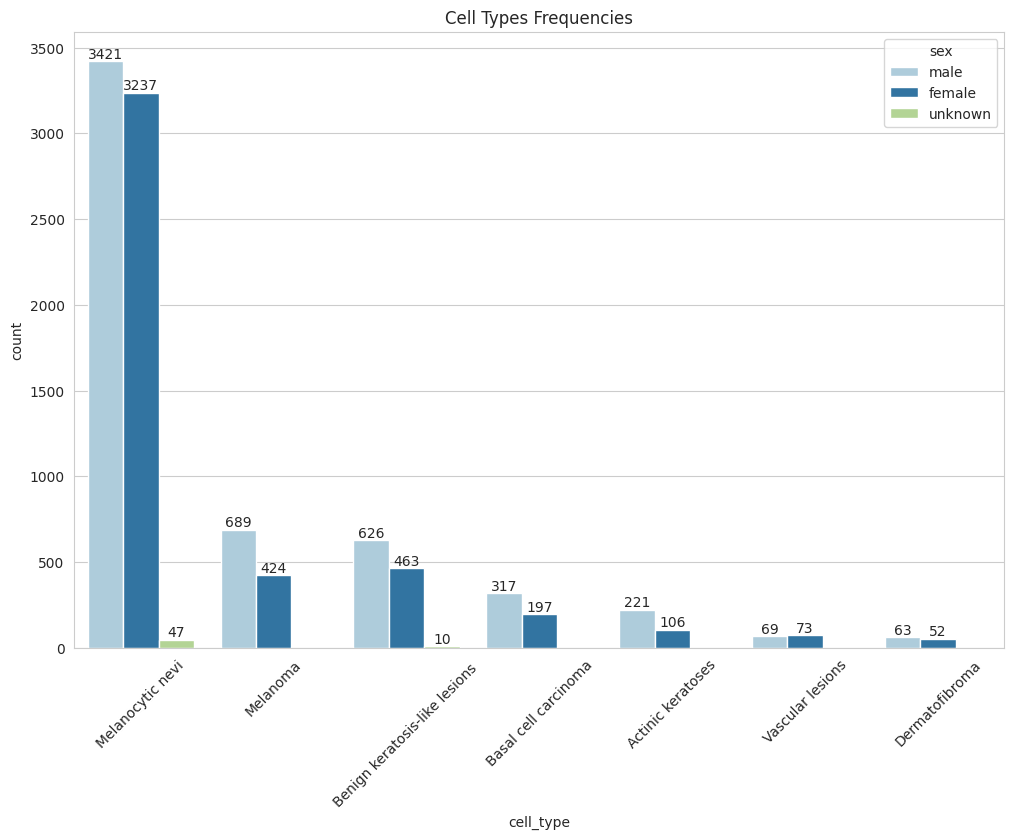

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

<ipython-input-17-8388bbb505b4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')


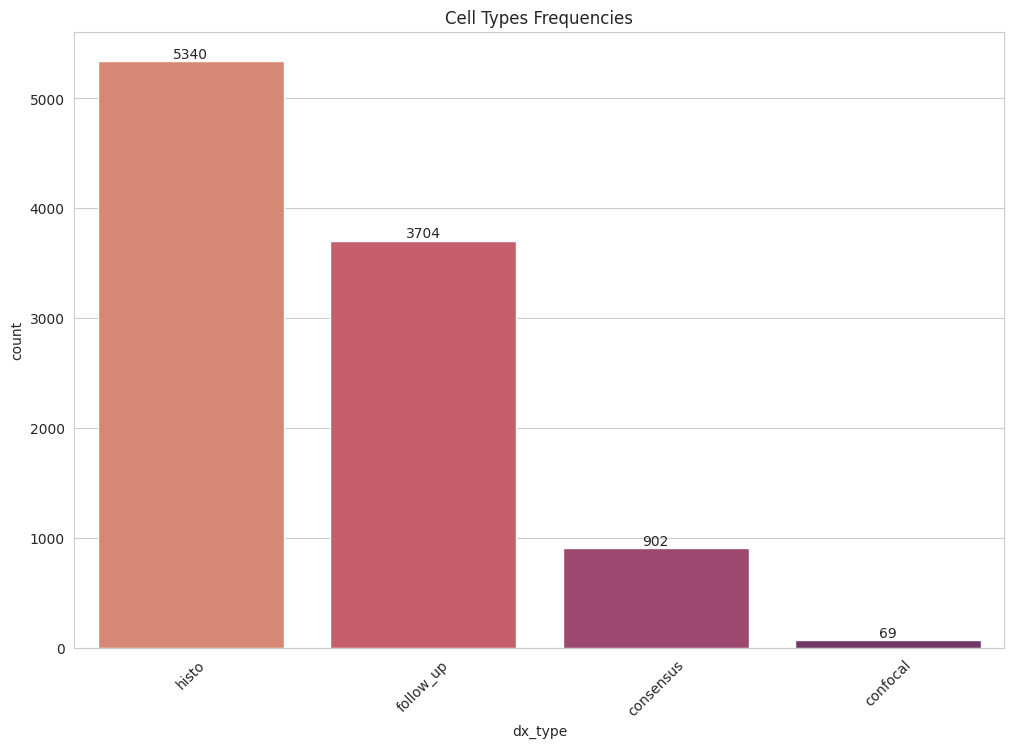

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

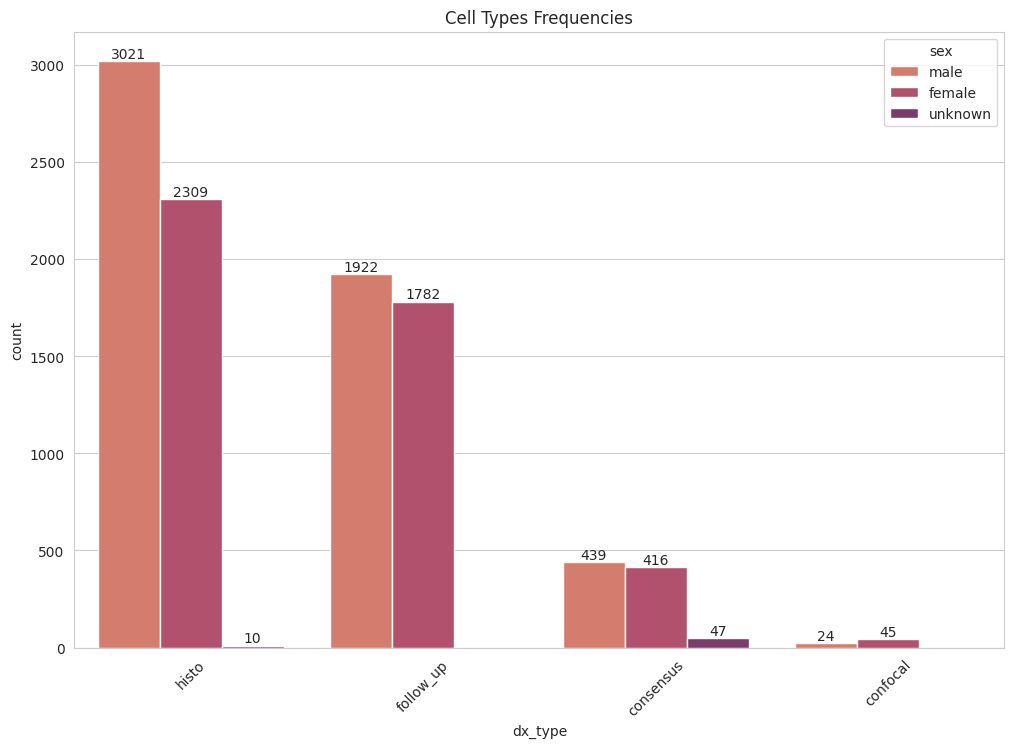

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',hue='sex', data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

<ipython-input-19-bd1bacd93587>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='localization',data=df, order = df['localization'].value_counts().index, palette = 'crest')


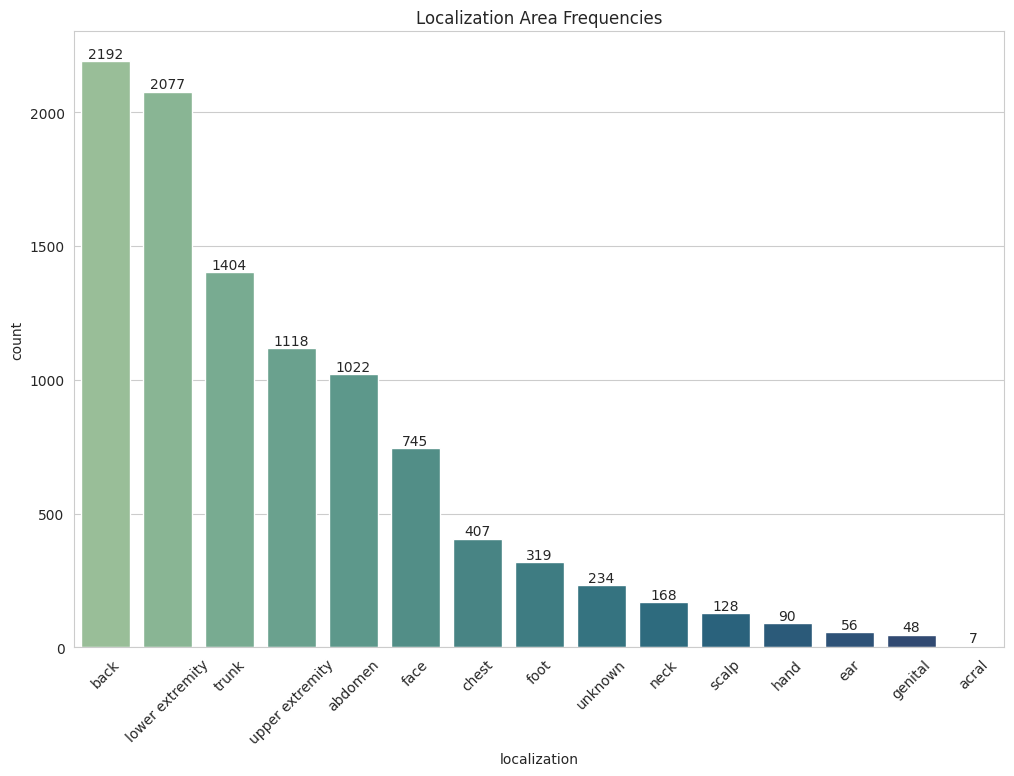

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

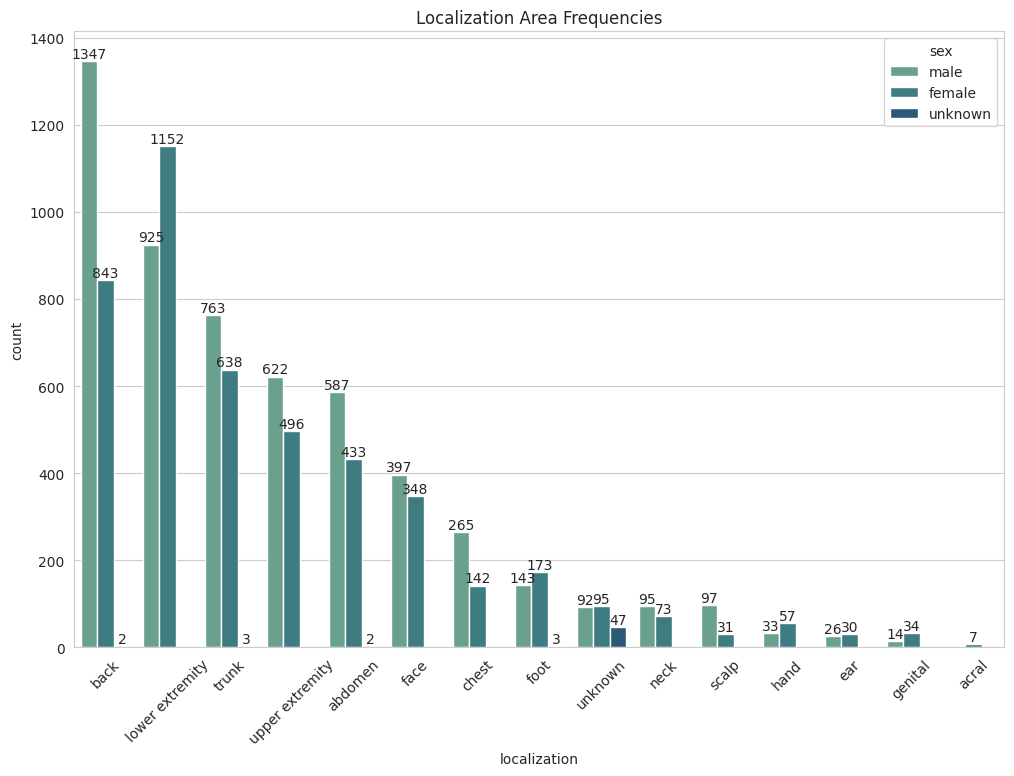

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',hue='sex', data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

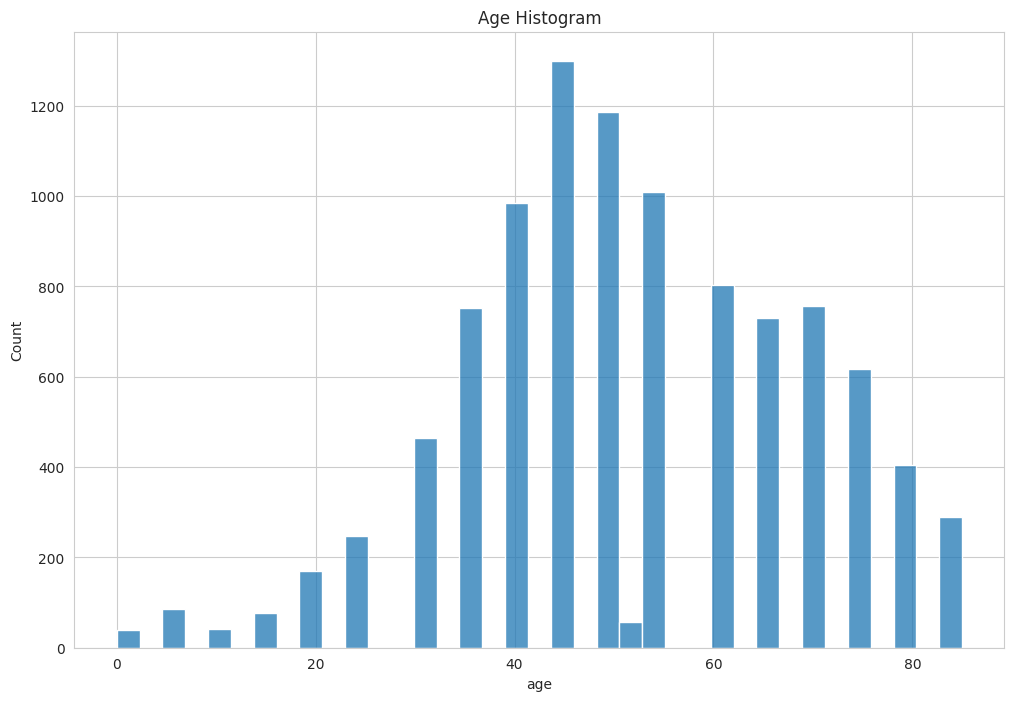

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age')
plt.title('Age Histogram')
plt.show()

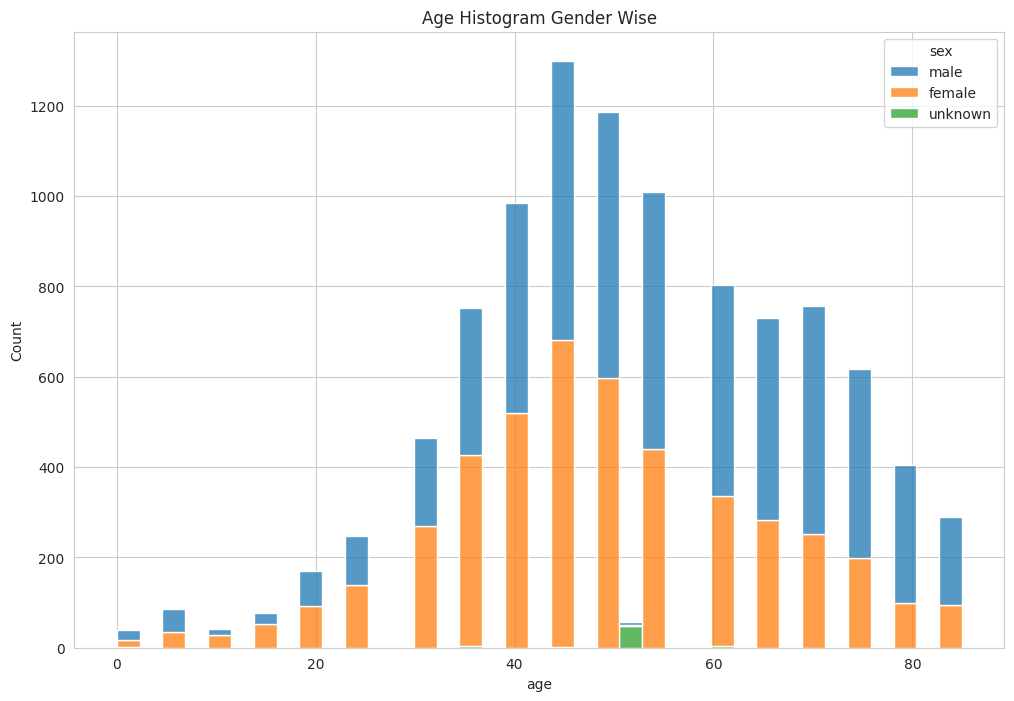

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise')
plt.show()

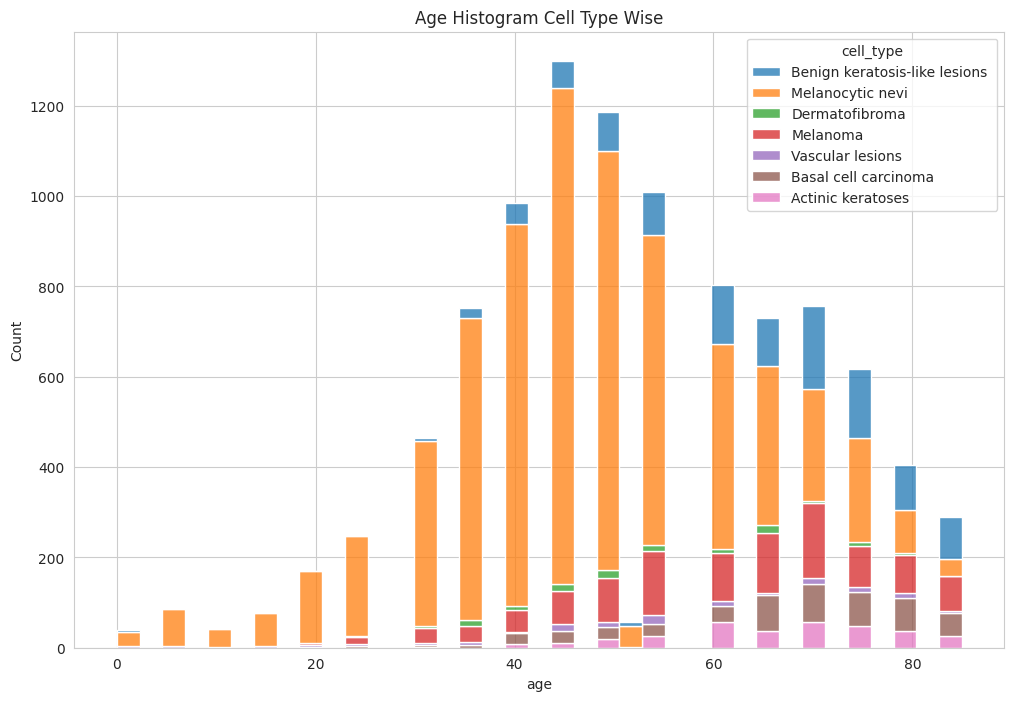

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

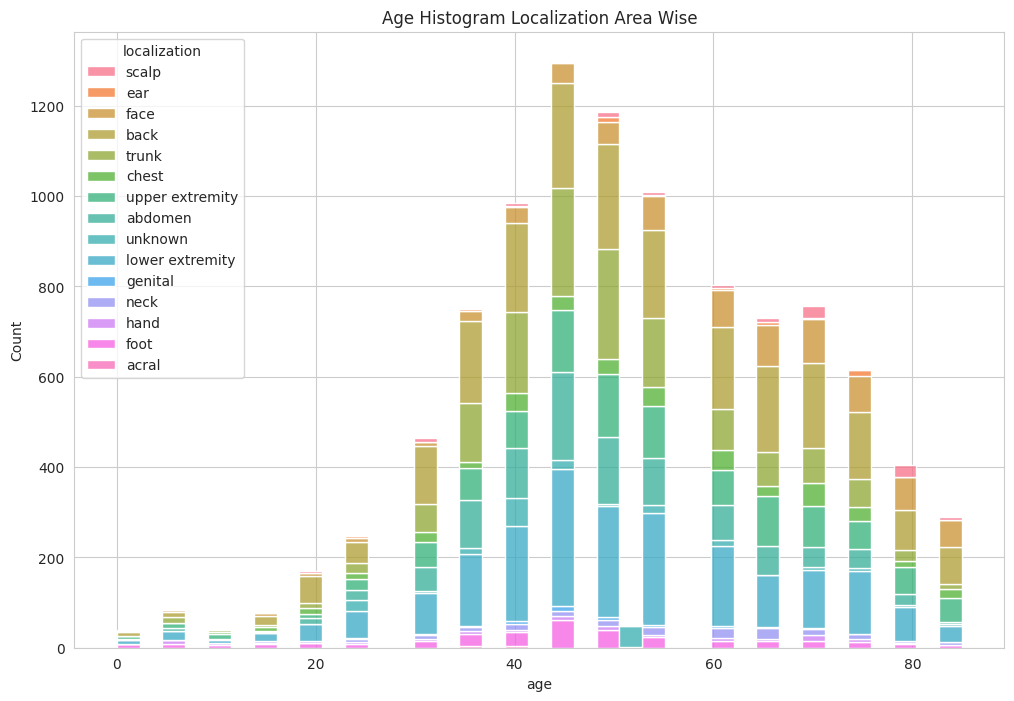

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

In [ ]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

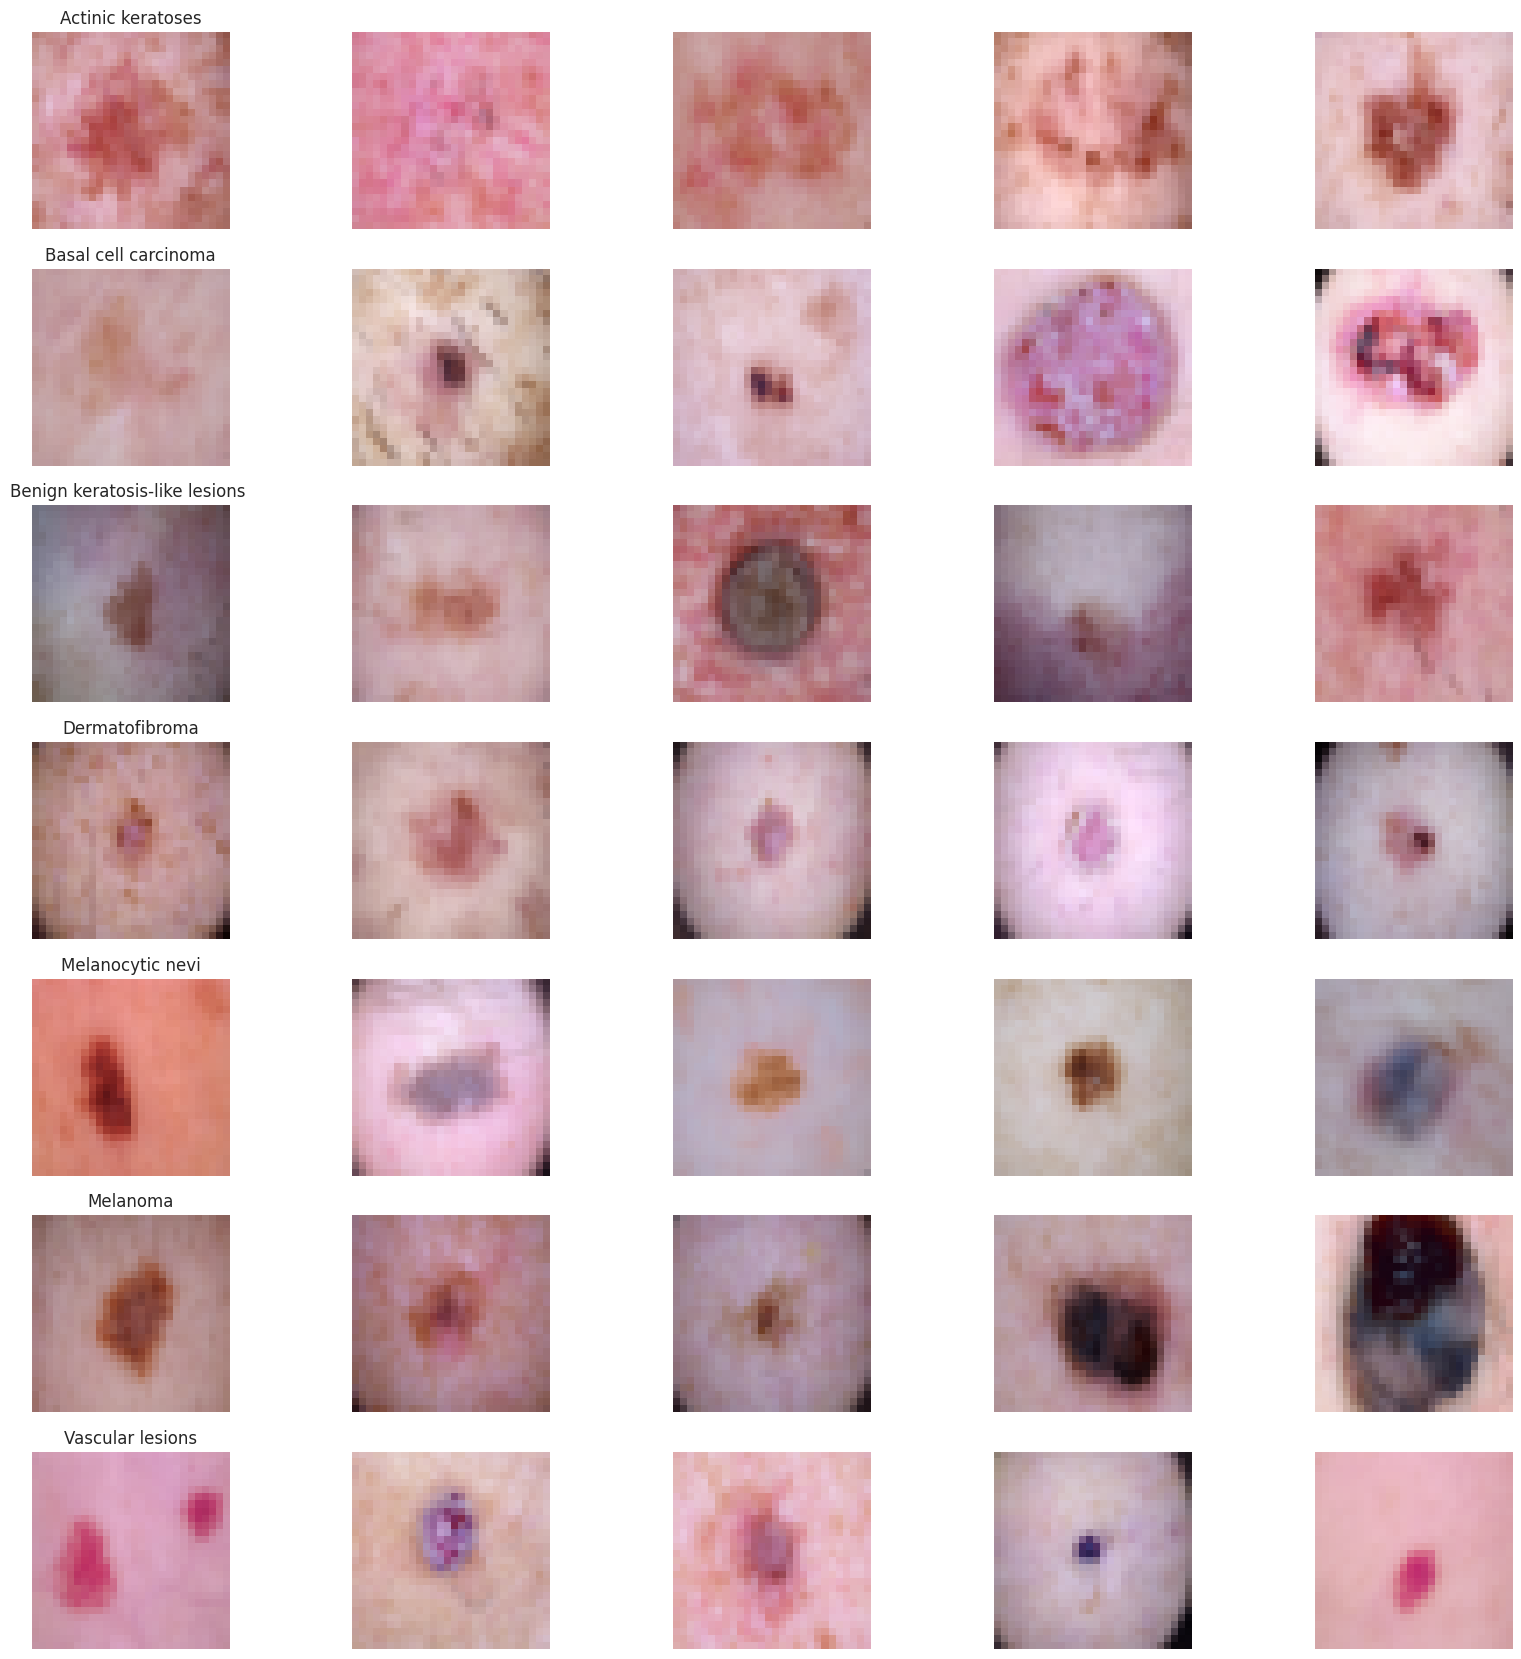

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

image
(28, 28, 3)    10015
Name: count, dtype: int64

In [ ]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(28, 28, 3))
x_test = x_test.reshape(x_test.shape[0], *(28, 28, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(28, 28, 3))

In [ ]:
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (28, 28, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [ ]:
# Define the optimizer
optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            learning_rate=0.00001)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
epochs = 50
batch_size = 60
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


<ipython-input-37-7f62f2671509>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


120/120 [==============================] - ETA: 0s - loss: 1.0195 - accuracy: 0.6627

120/120 [==============================] - 50s 401ms/step - loss: 1.0195 - accuracy: 0.6627 - val_loss: 0.9468 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 0.9003 - accuracy: 0.6748

120/120 [==============================] - 50s 414ms/step - loss: 0.9003 - accuracy: 0.6748 - val_loss: 0.8411 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.6873

120/120 [==============================] - 54s 449ms/step - loss: 0.8644 - accuracy: 0.6873 - val_loss: 0.8189 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 4/50
120/120 [==============================] - ETA: 0s - loss: 0.8293 - accuracy: 0.7001

120/120 [==============================] - 43s 355ms/step - loss: 0.8293 - accuracy: 0.7001 - val_loss: 0.8020 - val_accuracy: 0.7082 - lr: 0.0010
Epoch 5/50
120/120 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.7046

120/120 [==============================] - 45s 373ms/step - loss: 0.8161 - accuracy: 0.7046 - val_loss: 0.9787 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 6/50
120/120 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.7136

120/120 [==============================] - 41s 342ms/step - loss: 0.7954 - accuracy: 0.7136 - val_loss: 0.7733 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 7/50
120/120 [==============================] - ETA: 0s - loss: 0.7736 - accuracy: 0.7159

120/120 [==============================] - 53s 441ms/step - loss: 0.7736 - accuracy: 0.7159 - val_loss: 0.7535 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 8/50
120/120 [==============================] - ETA: 0s - loss: 0.7586 - accuracy: 0.7255

120/120 [==============================] - 40s 331ms/step - loss: 0.7586 - accuracy: 0.7255 - val_loss: 0.7174 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 9/50
120/120 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.7310

120/120 [==============================] - 46s 384ms/step - loss: 0.7366 - accuracy: 0.7310 - val_loss: 0.7238 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 10/50
120/120 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7351

120/120 [==============================] - 40s 331ms/step - loss: 0.7225 - accuracy: 0.7351 - val_loss: 0.7672 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 11/50
120/120 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.7362

120/120 [==============================] - 45s 372ms/step - loss: 0.7213 - accuracy: 0.7362 - val_loss: 0.6775 - val_accuracy: 0.7569 - lr: 0.0010
Epoch 12/50
120/120 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7417

120/120 [==============================] - 46s 381ms/step - loss: 0.7055 - accuracy: 0.7417 - val_loss: 0.7046 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 13/50
120/120 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.7414

120/120 [==============================] - 44s 363ms/step - loss: 0.7051 - accuracy: 0.7414 - val_loss: 0.6874 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 14/50
120/120 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.7484

120/120 [==============================] - 44s 362ms/step - loss: 0.6821 - accuracy: 0.7484 - val_loss: 0.6650 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 15/50
120/120 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.7562

120/120 [==============================] - 41s 341ms/step - loss: 0.6760 - accuracy: 0.7562 - val_loss: 0.6560 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 16/50
120/120 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7569

120/120 [==============================] - 44s 365ms/step - loss: 0.6662 - accuracy: 0.7569 - val_loss: 0.6869 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 17/50
120/120 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7579

120/120 [==============================] - 44s 366ms/step - loss: 0.6613 - accuracy: 0.7579 - val_loss: 0.6746 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 18/50
120/120 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.7566

120/120 [==============================] - 41s 343ms/step - loss: 0.6475 - accuracy: 0.7566 - val_loss: 0.6495 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 19/50
120/120 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.7660

120/120 [==============================] - 47s 390ms/step - loss: 0.6317 - accuracy: 0.7660 - val_loss: 0.6631 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 20/50
120/120 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.7614

120/120 [==============================] - 46s 384ms/step - loss: 0.6396 - accuracy: 0.7614 - val_loss: 0.6656 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 21/50
120/120 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.7615

120/120 [==============================] - 48s 400ms/step - loss: 0.6459 - accuracy: 0.7615 - val_loss: 0.6171 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 22/50
120/120 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.7634

120/120 [==============================] - 42s 347ms/step - loss: 0.6356 - accuracy: 0.7634 - val_loss: 0.6259 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 23/50
120/120 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.7722

120/120 [==============================] - 39s 326ms/step - loss: 0.6245 - accuracy: 0.7722 - val_loss: 0.6349 - val_accuracy: 0.7706 - lr: 0.0010
Epoch 24/50
120/120 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.7757

120/120 [==============================] - 45s 375ms/step - loss: 0.6099 - accuracy: 0.7757 - val_loss: 0.6193 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 25/50
120/120 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.7737

120/120 [==============================] - 47s 396ms/step - loss: 0.6106 - accuracy: 0.7737 - val_loss: 0.6143 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 26/50
120/120 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.7727

120/120 [==============================] - 46s 384ms/step - loss: 0.6159 - accuracy: 0.7727 - val_loss: 0.6438 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 27/50
120/120 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.7787

120/120 [==============================] - 46s 384ms/step - loss: 0.5942 - accuracy: 0.7787 - val_loss: 0.6583 - val_accuracy: 0.7681 - lr: 0.0010
Epoch 28/50
120/120 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.7766

120/120 [==============================] - 48s 396ms/step - loss: 0.5967 - accuracy: 0.7766 - val_loss: 0.6290 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 29/50
120/120 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7776

120/120 [==============================] - 46s 385ms/step - loss: 0.5975 - accuracy: 0.7776 - val_loss: 0.6161 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 30/50
120/120 [==============================] - ETA: 0s - loss: 0.5915 - accuracy: 0.7813

120/120 [==============================] - 48s 402ms/step - loss: 0.5915 - accuracy: 0.7813 - val_loss: 0.6198 - val_accuracy: 0.7681 - lr: 0.0010
Epoch 31/50
120/120 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.7856

120/120 [==============================] - 39s 324ms/step - loss: 0.5824 - accuracy: 0.7856 - val_loss: 0.6145 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 32/50
120/120 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7894

120/120 [==============================] - 45s 375ms/step - loss: 0.5659 - accuracy: 0.7894 - val_loss: 0.6448 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 33/50
120/120 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7881

120/120 [==============================] - 42s 349ms/step - loss: 0.5697 - accuracy: 0.7881 - val_loss: 0.6322 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 34/50
120/120 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7891

120/120 [==============================] - 41s 338ms/step - loss: 0.5710 - accuracy: 0.7891 - val_loss: 0.6429 - val_accuracy: 0.7731 - lr: 0.0010
Epoch 35/50
120/120 [==============================] - ETA: 0s - loss: 0.5676 - accuracy: 0.7895

120/120 [==============================] - 44s 365ms/step - loss: 0.5676 - accuracy: 0.7895 - val_loss: 0.6403 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 36/50
120/120 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7880

120/120 [==============================] - 44s 368ms/step - loss: 0.5597 - accuracy: 0.7880 - val_loss: 0.6709 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 37/50
120/120 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7957

120/120 [==============================] - 40s 330ms/step - loss: 0.5529 - accuracy: 0.7957 - val_loss: 0.6124 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 38/50
120/120 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.7943

120/120 [==============================] - 47s 393ms/step - loss: 0.5420 - accuracy: 0.7943 - val_loss: 0.6173 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 39/50
120/120 [==============================] - ETA: 0s - loss: 0.5426 - accuracy: 0.7973

120/120 [==============================] - 39s 326ms/step - loss: 0.5426 - accuracy: 0.7973 - val_loss: 0.6180 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 40/50
120/120 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.7933

120/120 [==============================] - 45s 372ms/step - loss: 0.5497 - accuracy: 0.7933 - val_loss: 0.6053 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 41/50
120/120 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.7979

120/120 [==============================] - 43s 359ms/step - loss: 0.5293 - accuracy: 0.7979 - val_loss: 0.6161 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 42/50
120/120 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.7969

120/120 [==============================] - 40s 330ms/step - loss: 0.5364 - accuracy: 0.7969 - val_loss: 0.6730 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 43/50
120/120 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.8004

120/120 [==============================] - 52s 433ms/step - loss: 0.5284 - accuracy: 0.8004 - val_loss: 0.6121 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 44/50
120/120 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.7992

120/120 [==============================] - 43s 358ms/step - loss: 0.5340 - accuracy: 0.7992 - val_loss: 0.6210 - val_accuracy: 0.7930 - lr: 0.0010
Epoch 45/50
120/120 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.8119

120/120 [==============================] - 45s 376ms/step - loss: 0.5127 - accuracy: 0.8119 - val_loss: 0.6380 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 46/50
120/120 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.8011

120/120 [==============================] - 44s 362ms/step - loss: 0.5254 - accuracy: 0.8011 - val_loss: 0.6217 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 47/50
120/120 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.8095

120/120 [==============================] - 39s 323ms/step - loss: 0.5132 - accuracy: 0.8095 - val_loss: 0.6292 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 48/50
120/120 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.8102

120/120 [==============================] - 47s 395ms/step - loss: 0.5147 - accuracy: 0.8102 - val_loss: 0.6358 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 49/50
120/120 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.8094

120/120 [==============================] - 47s 392ms/step - loss: 0.4989 - accuracy: 0.8094 - val_loss: 0.6394 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 50/50
120/120 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.8073

120/120 [==============================] - 47s 394ms/step - loss: 0.5033 - accuracy: 0.8073 - val_loss: 0.6084 - val_accuracy: 0.7818 - lr: 0.0010


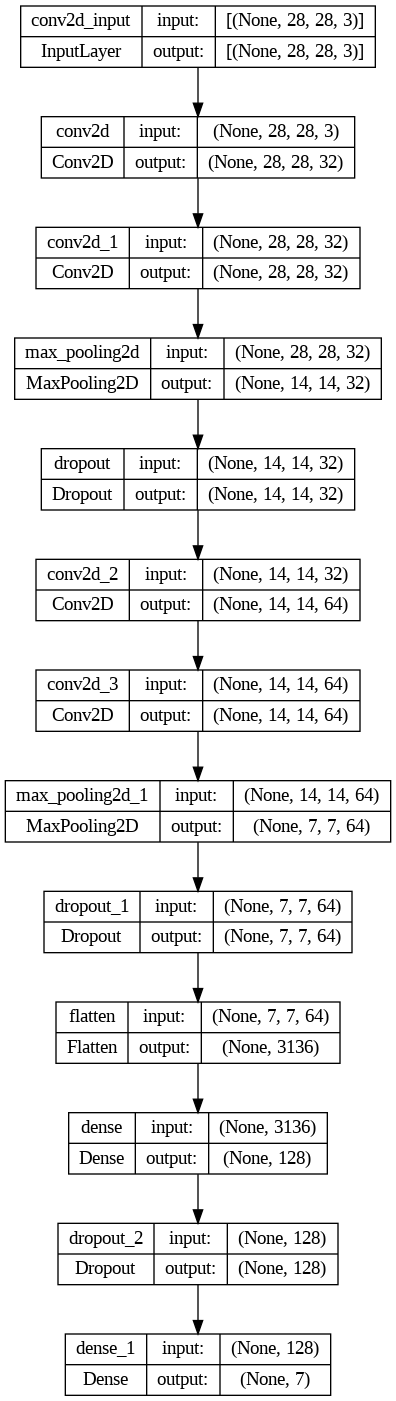

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

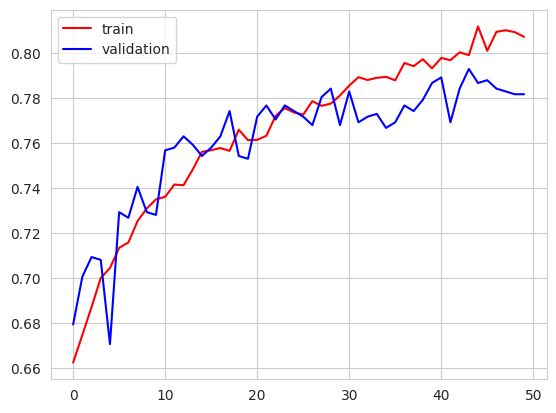

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

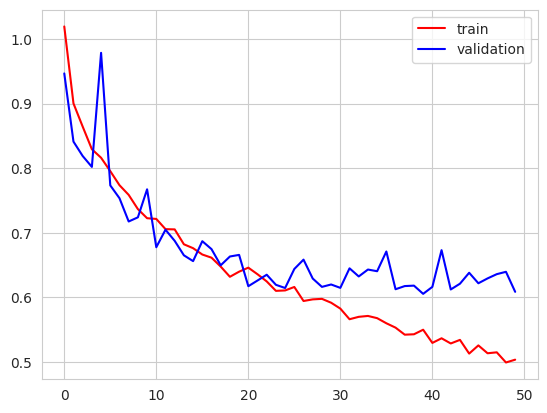

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 2s 62ms/step - loss: 0.6084 - accuracy: 0.7818
Validation: accuracy = 0.781796  ;  loss_v = 0.608409
Test: accuracy = 0.769845  ;  loss = 0.637611


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


26/26 [==============================] - 2s 62ms/step


In [ ]:
# Predict the values from the x_test dataset
Y_pred = model.predict(x_test)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

63/63 [==============================] - 4s 62ms/step
